# Basic Control Synthesis for Minigrid Environment

In [1]:
%load_ext autoreload

import gym
from IPython.display import Video
from sklearn.model_selection import train_test_split

# wombats imports
from wombats.systems import (StaticMinigridTSWrapper,
                             LavaComparison_noDryingOff)
from wombats.automaton import active_automata
from wombats.automaton import MinigridTransitionSystem
from wombats.learning import FlexfringeInterface

## Loading in the Specification

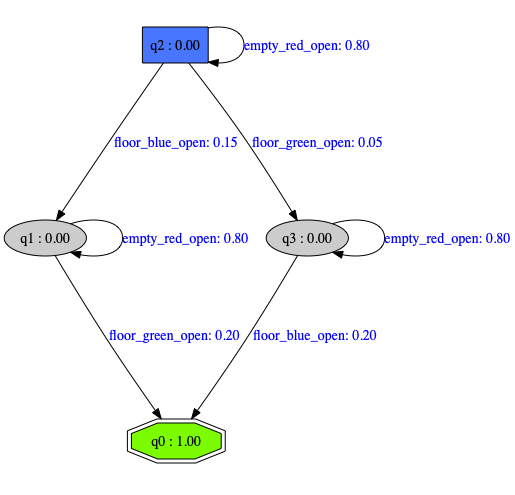

In [2]:
pdfa_config_file = 'wombats/config/PDFA_minigrid_synthesis_meeting.yaml'
pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=pdfa_config_file)
pdfa_specification.draw('basic_minigrid_pdfa')

## Learning the Specification

We will take this specification and learn it using `Flexfringe`

### Creating Training / Test Data

Here, we choose a 90/10 training/test split in our data using N samples fron the target specification.

In [3]:
num_samples = 50
max_trace_length = 20
(traces,
 trace_lengths,
 trace_probs) = pdfa_specification.generate_traces(num_samples, N=max_trace_length)

# create a training-test split for model validation after training 
test_size = 0.1
(traces_train, traces_test,
 traceLengths_train, traceLengths_test,
 trace_probs_train, trace_probs_test) = train_test_split(traces,
                                                         trace_lengths,
                                                         trace_probs,
                                                         test_size=test_size)

# Write learning data to files for inference
num_traces_train = len(traces_train)
num_traces_test = len(traces_test)
pdfa_specification.write_traces_to_file(traces_train, num_traces_train,
                                        traceLengths_train,
                                        f_name='meeting_minigrid_pdfa_train')
pdfa_specification.write_traces_to_file(traces_test, num_traces_test,
                                        traceLengths_test,
                                        f_name='meeting_minigrid_pdfa_test')

### Learning with `Flexfringe`

We are going to use the wombats wrapper to learn the specification.

In [4]:
flexfringe = FlexfringeInterface()
flexfringe.infer_model(get_help=True)

no learning options specified, printing tool help:
welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe --help  
Usage: flexfringe [OPTIONS]* [input dfa file]
      --version                   Display version information
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing
                                  /, default: "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default
                                  count_driven. Use any heuristic in the
                                  evaluation directory. It is often beneficial
                                  to write your own, as heuristics are very
                                  application specific.
  -d, --data-name=string          Name of the merge data class to use; default
                                  count_data. Use any heuristic in the
                                 

welcome, running git commit d1cf04ada0831d0605a3651971ef9a02091d8823 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=10 -x=0 -w=1 -a=1 -b=1 -f=1 -I=0 -t=1 -q=0 -y=0 -p=0.5 --output-dir=./dfa meeting_minigrid_pdfa_train 
sat_program : 
valid: kldistance
aic 1
alergia 1
alergia94 1
conflict_driven 1
conflict_edsm_driven 1
conflict_overlap_driven 1
count_driven 1
depth_driven 1
evidence_driven 1
fixed_depth_mse_error 1
full_overlap_driven 1
kldistance 1
likelihoodratio 1
mealy 1
mse_error 1
overlap4logs 1
overlap_driven 1
process_mining 1
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running m99972  m99963  x81  m99980  x36  

found intermediate solution with 3 and 3 red states
No valid solver specified, skipping...
dfasat running 

found intermediate solution with 3 and 1 red states
No valid solver specified, skipping...
dfasat running 

found intermediate solution with 3 and 1 red states
No valid

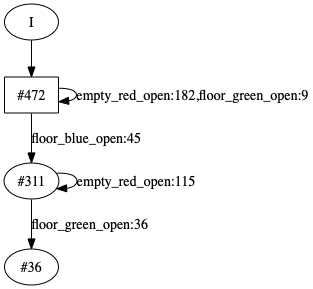

In [5]:
%autoreload 2
data = flexfringe.infer_model(training_file='meeting_minigrid_pdfa_train',
                              h='kldistance',
                              d='kl_data',
                              n='10',
                              x='0',
                              w='1',
                              a='1',
                              b='1',
                              f='1',
                              I='0',
                              t='1',
                              q='0',
                              y='0',
                              p='0.5')

flexfringe.draw_learned_model()

### Loading in / Processing the Learned Specification

The result from Flexfringe is NOT even an FDFA, so we must do a lot of processing to turn it into a proper PDFA:

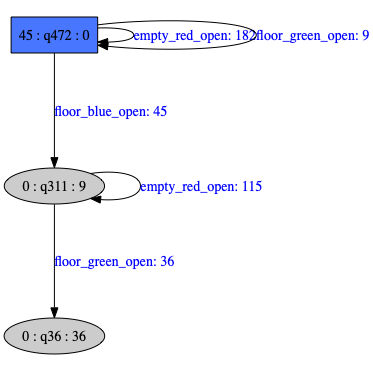

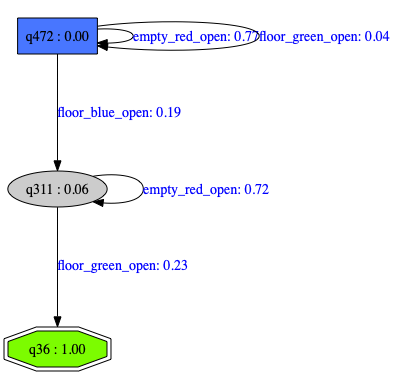

In [6]:
learned_fdfa = active_automata.get(automaton_type='FDFA',
                                   graph_data=flexfringe,
                                   graph_data_format='learning_interface')
learned_fdfa.draw('meeting_robot_learned_spec_fdfa')

learned_pdfa = active_automata.get(automaton_type='PDFA',
                                   graph_data=learned_fdfa,
                                   graph_data_format='fdfa_object',
                                   smooth_transitions=False,
                                   smoothing_amount=0.0000)
learned_pdfa.draw('meeting_robot_learned_spec_fdfa')

In [7]:
learned_pdfa._num_states

3

## Evaluating Learned Specification

We start by checking how different the most probable string is for the learned PDFA vs. the learning target.

In [8]:
(specification_MPS,
 specification_MPS_prob) = pdfa_specification.most_probable_string()
print(f'Specification MPS: {specification_MPS}')
print(f'Probability of Spec. MPS in PDFA"s Language: {specification_MPS_prob}')

learned_model_MPS, learned_model_MPS_prob = learned_pdfa.most_probable_string()
print(f'Learned MPS: {learned_model_MPS}')
print(f'Probability of Learned MPS in PDFA"s Language: {learned_model_MPS_prob}')

Specification MPS: ['floor_blue_open', 'floor_green_open']
Probability of Spec. MPS in PDFA"s Language: 0.03
Learned MPS: ['floor_blue_open', 'floor_green_open']
Probability of Learned MPS in PDFA"s Language: 0.04290254237288135


We also want to evaluate the learned LM's perplexity on the test set given the exact, know string probabilities from the learning target:

In [9]:
test_perplexity = learned_pdfa.perplexity(traces_test, trace_probs_test)
train_perplexity = learned_pdfa.perplexity(traces_train, trace_probs_train)
target_perplexity = pdfa_specification.perplexity(traces_test, trace_probs_test)

print(f"Test Perplexity of Learned Model: {test_perplexity}")
print(f"Training Perplexity of Learned Model: {train_perplexity}")
print(f"Perplexity of Target Model: {target_perplexity}")

Test Perplexity of Learned Model: 1.029793231935059
Training Perplexity of Learned Model: 1.0380485645102357
Perplexity of Target Model: 1.0289139866636532


## Loading in the Minigrid Transition System

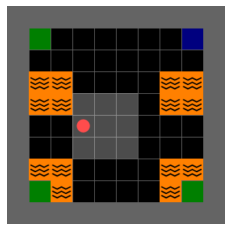

/Users/nicholasrenninger/Google Drive/Grad School/specification learning/code/DPFA_DTS_product_experiment/dfasatInvestigations/wombats/systems/minigrid.py:620: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


In [10]:
ENV_ID = 'MiniGrid-LavaComparison_noDryingOff-v0'
# ENV_ID = 'MiniGrid-DistShift1-v0'
# ENV_ID = 'MiniGrid-LavaGapS5-v0'
# ENV_ID = 'MiniGrid-KeyCorridorS3R1-v0'
env = gym.make(ENV_ID)

env = StaticMinigridTSWrapper(env, actions_type='simple_static')
env.reset()
env.render_notebook()

minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
                                  graph_data_format='minigrid')
# minigrid_TS.draw('_'.join([ENV_ID, 'TS']))

In [11]:
minigrid_TS.observations

{'empty_red_open', 'floor_blue_open', 'floor_green_open', 'lava_red_open'}

In [12]:
list(minigrid_TS.actions)

[<SimpleStaticActions.north: 0>,
 <SimpleStaticActions.south: 1>,
 <SimpleStaticActions.east: 2>,
 <SimpleStaticActions.west: 3>]

## Building the Product Automaton

In [13]:
product = active_automata.get(automaton_type='Product',
                              graph_data=(minigrid_TS,
                                          learned_pdfa),
                             show_steps=False)
# product.draw('_'.join([ENV_ID, '_basic_product']))

In [14]:
product.observations

{'empty_red_open', 'floor_blue_open', 'floor_green_open', 'lambda'}

## Computing the Most-Probable, Possible Controller

In [15]:
%autoreload 2
(controls,
 prob_of_controls_under_spec) = product.compute_strategy()

print(f'Optimal Controls: {controls}')
print(f'Probability of Generated TS Observations in Spec: ' +
      f'{prob_of_controls_under_spec}')

Optimal Controls: ['north', 'north', 'north', 'north', 'east', 'east', 'east', 'east', 'east']
Probability of Generated TS Observations in Spec: 0.0010348025797183996


## Applying Controller to System

In [16]:
output_string, visited_states, video_path = minigrid_TS.run(controls,
                                                            record_video=True)
print(output_string)
print(visited_states)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")

['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_blue_open']
['(3, 5), right', '(3, 4), right', '(3, 3), right', '(3, 2), right', '(3, 1), right', '(4, 1), right', '(5, 1), right', '(6, 1), right', '(7, 1), right', '(8, 1), right']
